## <b>EDA and Data cleaning</b> notebook (Nr 1) for <b>Project 2</b> of General Assembly DSIR-0320 
by Martijn de Vries </br>
martijndevries91@gmail.com

## Problem Statement

A real estate company in Ames, Iowa is looking for a new and improved way to evaluate the market value of a house. Using the Ames data set as training data, I will build a predictive linear regression model to predict the sale price of a house.

To gauge the model performance, I will compare my results against a 'benchmark model', which is a simple OLS regression of total living area versus sale price. How much can a more complex model improve over this simple basic model? I will try out different models with different numbers of features using different linear regression techniques, and ultimately identify which model does the best job at predicting the market value of the house. o evaluate and compare models, I will use the r2-score, as well as the root mean squared error (RMSE). 

## In this notebook

I will clean the data and do some basic EDA. Because there are quite a lot of missing values in both the training and testing dataset, I will make some assumptions and imputations. The cleaned data are saved as train_cleaned.csv and test_cleaned.csv

The function clean_ames at the bottom of this notebook summarizes all the steps taken in the data cleaning process.

Two important resources - <br>
The original paper (De Cock 2011): https://jse.amstat.org/v19n3/decock.pdf <br>
The data description/dictionary: https://jse.amstat.org/v19n3/decock/DataDocumentation.txt

In [44]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [45]:
#let's have some basic info about what the data looks like
ames_df = pd.read_csv('../datasets/train.csv')
print(ames_df.shape)
ames_df.head()

(2051, 81)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [46]:
#what about the test data?
ames_test = pd.read_csv('../datasets/test.csv')
print(ames_test.shape)

(878, 80)


That's a lot of columns! What kind of variables are they?

In [47]:
print(ames_df.dtypes.value_counts())

object     42
int64      28
float64    11
dtype: int64


I don't really care about PID, so let's get rid of that one. Fewer columns can only be a good thing

In [48]:
ames_df = ames_df.drop(columns=['PID'])

Most of those 'object' columns are probably categorical variables, which can be either nominal (no natural predetermined rank, just categories) and ordinal (where the categories have some type of order).

Let's print out some descriptive stats of the numerical columns

In [49]:
ames_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2051.0,1474.033642,843.980841,1.0,753.5,1486.0,2198.00,2930.0
MS SubClass,2051.0,57.008776,42.824223,20.0,20.0,50.0,70.00,190.0
Lot Frontage,1721.0,69.055200,23.260653,21.0,58.0,68.0,80.00,313.0
Lot Area,2051.0,10065.208191,6742.488909,1300.0,7500.0,9430.0,11513.50,159000.0
Overall Qual,2051.0,6.112140,1.426271,1.0,5.0,6.0,7.00,10.0
Overall Cond,2051.0,5.562165,1.104497,1.0,5.0,5.0,6.00,9.0
Year Built,2051.0,1971.708922,30.177889,1872.0,1953.5,1974.0,2001.00,2010.0
Year Remod/Add,2051.0,1984.190151,21.036250,1950.0,1964.5,1993.0,2004.00,2010.0
Mas Vnr Area,2029.0,99.695909,174.963129,0.0,0.0,0.0,161.00,1600.0
BsmtFin SF 1,2050.0,442.300488,461.204124,0.0,0.0,368.0,733.75,5644.0


Scanning through all these comments,it all seems to make sense! Nothing standing out as particularly weird or strange here.

Let's also plot a histogram of the target variable, the sale price

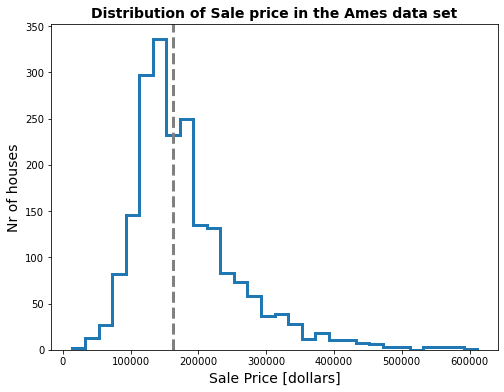

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(ames_df['SalePrice'], bins=30, histtype='step', linewidth='3')
ax.set_xlabel('Sale Price [dollars]', fontsize=14)
ax.set_ylabel('Nr of houses', fontsize=14)
ax.axvline(ames_df['SalePrice'].median(), linestyle='dashed', color='grey', linewidth=3)
ax.set_title('Distribution of Sale price in the Ames data set', fontsize=14, fontweight='bold')
plt.savefig('../figures/saleprice_dist.png', dpi=300)
plt.show()

The distribution of sale price is pretty right-skewed. I will keep this in mind, because it might be useful to do a log-transform of the data when we get to the modeling stage.

I would like to know how many missing values are in each of the columns. For this I'll make a bar plot. To keep the size of the plot manageable, I will only include columns with at least  1 missing value

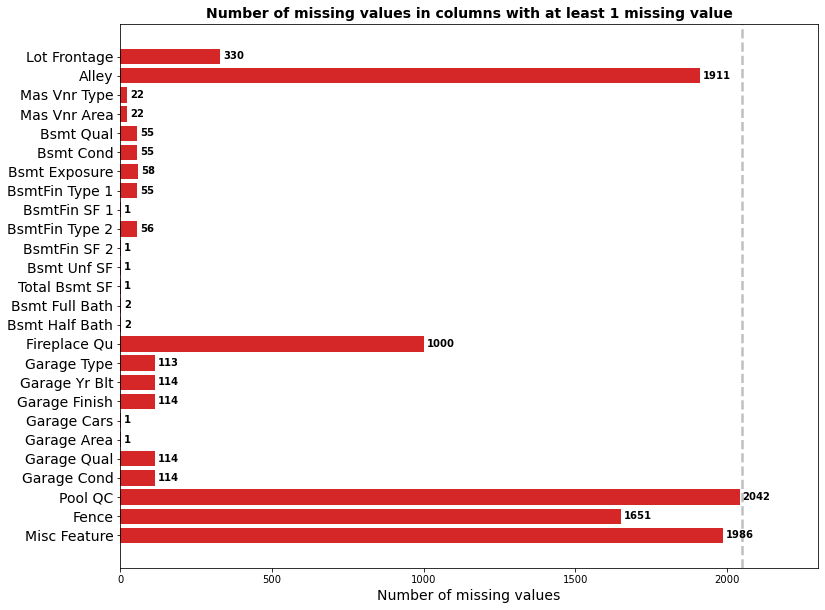

In [65]:
#make bar plot of missing values
nan_l, col_l = [], []
for i, col in enumerate(ames_df.columns): 
    mval = ames_df[col].isna().sum()
    if mval > 0: 
        nan_l.append(mval)
        col_l.append(col)
nan_arr = np.array(nan_l)
fig, ax = plt.subplots(figsize=(12.5 ,10))
y_pos = np.arange(len(col_l))

ax.barh(y_pos, nan_arr, color='tab:red')

#this is a little awkward, but I couldn't find a better way to increase the fontsize of the y-labels
#if you don't first set yticks specifically, matplotlib gives you a warning
#apparently in the newest version of matplotlib, you can specify labels and fontsize in set_yticks
ax.set_yticks(y_pos)
ax.set_yticklabels(labels=col_l, fontsize=14)

ax.invert_yaxis() 

#add labels: (note, there is a new function called 
#ax.bar_label but I have an older version of matplotlib installed)
#I copied this from https://stackoverflow.com/questions/30228069/how-to-display-the-value-on-horizontal-bars
for i, v in enumerate(nan_arr):
    ax.text(v + 10, i + 0.15, str(int(v)), color='black', fontweight='bold')
    
ax.set_xlabel('Number of missing values', fontsize=14)
ax.set_xlim(0, 2300)
#add a dashed line to indicate the total number of rows in the data set
ax.axvline(ames_df.shape[0], linestyle='dashed', alpha=0.5, color='grey', linewidth=2.5)
ax.set_title('Number of missing values in columns with at least 1 missing value', fontsize=14, fontweight='bold')

plt.savefig('../figures/missingvals.png', dpi=300)
plt.show()

To figure out more about why these columns have missing values, let's get some information about them
For each column with missing values: 

If the data is continuous, print the mean, min and max values <br>
If the data is categorical, do a value_counts()

In [8]:
for col in col_l:
    if (ames_df[col].dtypes == 'float64') or (ames_df[col].dtypes == 'int64'):
        col_mean = str(round(ames_df[col].mean(),2))
        col_min = str(round(ames_df[col].min(),2))
        col_max =  str(round(ames_df[col].max(),2))
        print(f'Column: {col} is continous')
        print(f'Mean: {col_mean} min value: {col_min} max value {col_max} \n')
    elif ames_df[col].dtypes == 'object':
        print(f'Column: {col} is categorical')
        print(ames_df[col].value_counts(), '\n')

        

Column: Lot Frontage is continous
Mean: 69.06 min value: 21.0 max value 313.0 

Column: Alley is categorical
Grvl    85
Pave    55
Name: Alley, dtype: int64 

Column: Mas Vnr Type is categorical
None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64 

Column: Mas Vnr Area is continous
Mean: 99.7 min value: 0.0 max value 1600.0 

Column: Bsmt Qual is categorical
TA    887
Gd    864
Ex    184
Fa     60
Po      1
Name: Bsmt Qual, dtype: int64 

Column: Bsmt Cond is categorical
TA    1834
Gd      89
Fa      65
Po       5
Ex       3
Name: Bsmt Cond, dtype: int64 

Column: Bsmt Exposure is categorical
No    1339
Av     288
Gd     203
Mn     163
Name: Bsmt Exposure, dtype: int64 

Column: BsmtFin Type 1 is categorical
GLQ    615
Unf    603
ALQ    293
BLQ    200
Rec    183
LwQ    102
Name: BsmtFin Type 1, dtype: int64 

Column: BsmtFin SF 1 is continous
Mean: 442.3 min value: 0.0 max value 5644.0 

Column: BsmtFin Type 2 is categorical
Unf    1749
Rec 

Now going over this one by one:
For the Lot Frontage: It could be that 'NaN' just means no lot frontage, but I'm pretty sure that the vast majority of houses is required to have lot frontage. 15% of houses having no lot frontage seems like a lot. It may just mean there is genuinely no information.

What if we use imputation for this? The simple thing to do would be to just take the median lot frontage of the set and impute that. But thinking about this a little more - assuming that the lot area is a square and bounded by a street on one side, the lot frontage should be somewhat close to the square root of the lot area. 

This is obviously a rough assumption, but it might be better than just taking the median overall. At the same time, it would ensure that lot area and frontage are going to be strongly correlated, which would weaken the LINEM assumptions (ie the model would not be good for inference). But since I'm building a predictive model, that's probably not as big of a deal

313.0


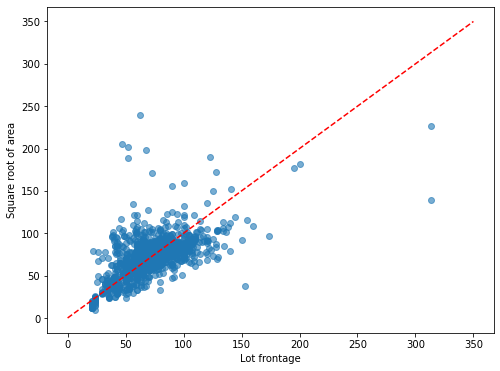

26.48374151136369


In [9]:
area_lf = ames_df['Lot Area'][ames_df['Lot Frontage'].isna() == False]
lotfrontage = ames_df['Lot Frontage'][ames_df['Lot Frontage'].isna() == False]
print(lotfrontage.max())
#what's the average difference between the square root of the area and the lot frontage?
diff = np.mean(np.sqrt(area_lf) - lotfrontage)

fig, ax = plt.subplots(figsize=(8,6))

xs = np.linspace(0, 350, 40)
ax.scatter(lotfrontage, np.sqrt(area_lf)-diff, alpha=0.6)
ax.plot(xs, xs, color='red', linestyle='dashed')
ax.set_xlabel('Lot frontage')
ax.set_ylabel('Square root of area')
plt.show()
print(diff)

That seems like a reasonable assumption for a predictive model. Let's impute lot frontage with sqrt(area) - diff, where diff is calculated above as 26.45.
Let's also max out the lot frontage at the maximum value measured in the other points

In [10]:
isna_inds = np.where(ames_df['Lot Frontage'].isna() == True)[0]
fill_vals =  np.sqrt(ames_df.iloc[isna_inds]['Lot Area']) - diff
ames_df['Lot Frontage'].fillna(fill_vals, inplace=True)

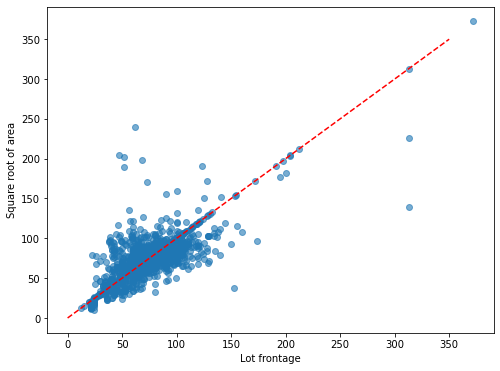

In [11]:
area_lf = ames_df['Lot Area'][ames_df['Lot Frontage'].isna() == False]
lotfrontage = ames_df['Lot Frontage'][ames_df['Lot Frontage'].isna() == False]

#what's the average difference between the square root of the area and the lot frontage?
fig, ax = plt.subplots(figsize=(8,6))

xs = np.linspace(0, 350, 40)
ax.scatter(lotfrontage, np.sqrt(area_lf)-diff, alpha=0.6)
ax.plot(xs, xs, color='red', linestyle='dashed')
ax.set_xlabel('Lot frontage')
ax.set_ylabel('Square root of area')
plt.show()

Looking down the list above, there are a few columns where from context and the data description, it seems that 'NA' just means 'not applicable', which means that feature isn't there. Pandas interprets this as NaN when reading in the file.

Those columns seem to be 1) Alley, 2) Fireplace Qu, 3) Pool QC, 4) Fence, and 5) Misc Feature. The basement and garage-related columns are a little more complex because they have columns that are related to each other - so I'll look at them seperately. But for these 5 we can just impute a 'Not Applicable' value, which means that feature does not exist for that particular house. I can't use 'NA', because then pandas will again read it in as NaN when I save and reload the cleaned data in another notebook. So I'll use 'NP' for 'Not Present'.

In [12]:
NA_features = ['Alley', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature']
for feature in NA_features:
    ames_df[feature].fillna('NP', inplace=True)

In [13]:
ames_df.shape

(2051, 80)

The next two variables evaluate Masonry veneer: the type, and the area. They have the same number of missing values. Let's check if they are exactly the same rows:

In [14]:
#display the Mas Vnr columns where Mas Vnr Type is NaN
ames_df[['Mas Vnr Type', 'Mas Vnr Area']][ames_df['Mas Vnr Type'].isna() == True]

,Mas Vnr Type,Mas Vnr Area
22,NaN,NaN
41,NaN,NaN
86,NaN,NaN
212,NaN,NaN
276,NaN,NaN
338,NaN,NaN
431,NaN,NaN
451,NaN,NaN
591,NaN,NaN
844,NaN,NaN


For Mas Vnr Type, we might just impute the most common value, which is 'None'. As a sidenote, the data description does mention an extra category 'CBlock', that I don't see in this data. It might be that these are the NaN values, or that they already have been cleaned. 

For Mas Vnr Area, if I'm saying that if there is no veneer type, the veneer area will logically also be zero for those houses

In [15]:
ames_df['Mas Vnr Type'].fillna('None', inplace=True)
print(ames_df['Mas Vnr Type'].value_counts())
ames_df['Mas Vnr Area'].fillna(0, inplace=True)

None       1240
BrkFace     630
Stone       168
BrkCmn       13
Name: Mas Vnr Type, dtype: int64


The next eleven columns with missing numbers all relate to 'Bsmt' (Basement). Just like with the Alley, at least some of these values probably just mean 'there is no basement'. For the first two columns: basement quality and basement height (condition), we will just impute 'NP' ('not present')

In [16]:
ames_df['Bsmt Qual'].fillna('NP', inplace=True)
ames_df['Bsmt Cond'].fillna('NP', inplace=True)

In [17]:
nb_inds = np.where(ames_df['Bsmt Qual'] == 'NP')[0]
ames_df.iloc[nb_inds, 31:40].head()

,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating
12,NP,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA
93,NP,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA
114,NP,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA
146,NP,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA
183,NP,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall


There are 3 other Basement columns that had as much or more NaNs as the above two columns: 'Bsmt Exposure', 'BsmtFin Type 1' and 'BsmtFin Type 2'. Most of those rows are probably NaN for the same reason

In [18]:
#Find where I just set Bsmt Qual to 'NB', and set the same category for these 3 basement variables
nb_inds = ames_df[ames_df['Bsmt Qual'] == 'NP'].index
ames_df.loc[nb_inds, ['Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']] = 'NP'

In [19]:
#how many NaNs are left for the basement columns?
bsmt_cols = [col for col in ames_df.columns if 'Bsmt' in col]
ames_df[bsmt_cols].isna().sum()

Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     3
BsmtFin Type 1    0
BsmtFin SF 1      1
BsmtFin Type 2    1
BsmtFin SF 2      1
Bsmt Unf SF       1
Total Bsmt SF     1
Bsmt Full Bath    2
Bsmt Half Bath    2
dtype: int64

In [20]:
ames_df[ames_df['Bsmt Exposure'].isna() == True][bsmt_cols]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
1456,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,0.0,0.0
1547,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0
1997,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0


In [21]:
#Impute the most common value, which is 'No'
nds = ames_df[ames_df['Bsmt Exposure'].isna() == True].index
ames_df.at[nds, 'Bsmt Exposure'] = 'No'

In [22]:
ames_df[ames_df['BsmtFin SF 1'].isna() == True][bsmt_cols]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
1327,NP,NP,NP,NP,NaN,NP,NaN,NaN,NaN,NaN,NaN


'SF' are square footage variables, so we can simply impute zero, as is the case for the other rows with no basement

In [23]:
nds = ames_df[ames_df['BsmtFin SF 1'].isna() == True].index
ames_df.at[nds, ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']] = 0

In [24]:
ames_df[ames_df['BsmtFin Type 2'].isna() == True][bsmt_cols]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
1147,Gd,TA,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0


I will just impute the most common value here, which is 'Unfinished'

In [25]:
ames_df.at[ames_df['BsmtFin Type 2'].isna() == True, 'BsmtFin Type 2'] = 'Unf'

For the final basement-related cols, Full and Half bath, I will just impute the median

In [26]:
ames_df['Bsmt Full Bath'].fillna(ames_df['Bsmt Full Bath'].median(), inplace=True)
ames_df['Bsmt Half Bath'].fillna(ames_df['Bsmt Half Bath'].median(), inplace=True)

Making progress! What's left?

In [27]:
{k:v for k,v in zip(ames_df.isna().sum().index, ames_df.isna().sum().values) if v > 0}

{'Garage Type': 113,
 'Garage Yr Blt': 114,
 'Garage Finish': 114,
 'Garage Cars': 1,
 'Garage Area': 1,
 'Garage Qual': 114,
 'Garage Cond': 114}

Similar to the Basement columns, I can assume that NaN values for Qual, Cond, Type, Built and Finish all just mean there is no garage to begin with. If NaN values for Cars and Areas are in the same rows, I can just them to zero.

In [28]:
ames_df['Garage Type'].fillna('NP', inplace=True)
gar_inds = ames_df[ames_df['Garage Type'] == 'NP'].index
ames_df.loc[gar_inds, ['Garage Finish', 'Garage Qual', 'Garage Cond']] = 'NP'
ames_df.loc[gar_inds, ['Garage Yr Blt']] = 0 

{k:v for k,v in zip(ames_df.isna().sum().index, ames_df.isna().sum().values) if v > 0}

{'Garage Yr Blt': 1,
 'Garage Finish': 1,
 'Garage Cars': 1,
 'Garage Area': 1,
 'Garage Qual': 1,
 'Garage Cond': 1}

There seems to be one row where the Garage Type is determined, but nothing else. Annoying..

In [29]:
gar_cols = [col for col in ames_df.columns if 'Garage' in col]
ames_df[(ames_df['Garage Qual'].isna() == True)][gar_cols]

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1712,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


I will use modes (for categorical columns) and medians (for numerical ones) to fill out this final row

In [30]:
ind = ames_df[(ames_df['Garage Qual'].isna() == True)].index
ames_df.loc[ind, 'Garage Yr Blt'] = ames_df['Garage Yr Blt'].median()
ames_df.loc[ind, 'Garage Cars'] = ames_df['Garage Cars'].median()
ames_df.loc[ind, 'Garage Area'] = ames_df['Garage Area'].median()
ames_df.loc[ind, 'Garage Finish'] = ames_df['Garage Finish'].mode()[0]
ames_df.loc[ind, 'Garage Qual'] = ames_df['Garage Qual'].mode()[0]
ames_df.loc[ind, 'Garage Cond'] = ames_df['Garage Cond'].mode()[0]

In [31]:
{k:v for k,v in zip(ames_df.isna().sum().index, ames_df.isna().sum().values) if v > 0}

{}

Now let's look at datatypes. Since there are a lot of columns, go through it by datatype

In [32]:
for col in ames_df.columns:
    if ames_df[col].dtype == 'int64':
        print(col)

Id
MS SubClass
Lot Area
Overall Qual
Overall Cond
Year Built
Year Remod/Add
1st Flr SF
2nd Flr SF
Low Qual Fin SF
Gr Liv Area
Full Bath
Half Bath
Bedroom AbvGr
Kitchen AbvGr
TotRms AbvGrd
Fireplaces
Wood Deck SF
Open Porch SF
Enclosed Porch
3Ssn Porch
Screen Porch
Pool Area
Misc Val
Mo Sold
Yr Sold
SalePrice


MS SubClass should probably be object type, since it's categorical.

In [33]:
ames_df['MS SubClass'] = ames_df['MS SubClass'].astype('object')

In [34]:
for col in ames_df.columns:
    if ames_df[col].dtype == 'float64':
        print(col)

Lot Frontage
Mas Vnr Area
BsmtFin SF 1
BsmtFin SF 2
Bsmt Unf SF
Total Bsmt SF
Bsmt Full Bath
Bsmt Half Bath
Garage Yr Blt
Garage Cars
Garage Area


I'll change the countable variables (Full Bath, Half Bath, and Cars) to integers. Year could be both float or int, but that's not really gonna make a big difference.

In [35]:
cols_to_change = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars']
for col in cols_to_change:
    ames_df[col] = ames_df[col].astype('int64')

Finally, object types:

In [36]:
for col in ames_df.columns:
    if ames_df[col].dtype == 'object':
        print(col)

MS SubClass
MS Zoning
Street
Alley
Lot Shape
Land Contour
Utilities
Lot Config
Land Slope
Neighborhood
Condition 1
Condition 2
Bldg Type
House Style
Roof Style
Roof Matl
Exterior 1st
Exterior 2nd
Mas Vnr Type
Exter Qual
Exter Cond
Foundation
Bsmt Qual
Bsmt Cond
Bsmt Exposure
BsmtFin Type 1
BsmtFin Type 2
Heating
Heating QC
Central Air
Electrical
Kitchen Qual
Functional
Fireplace Qu
Garage Type
Garage Finish
Garage Qual
Garage Cond
Paved Drive
Pool QC
Fence
Misc Feature
Sale Type


That looks right, as far as I can tell.

Now finally, let's write a function to automate this process:

In [37]:
def clean_ames(df):
    """
    Function to clean the ames dataset, for either the input training or testing data. 
    More information and justification about each of the steps can be found in the above notebook
    """
    #Drop Id and PID columns
    df = df.drop(columns=['PID'])
    
    #all features where we can simple replace NaNs by 'NP' (Not Present)
    NA_features = ['Alley', 'Garage Type', 'Fireplace Qu', 'Pool QC', 'Fence', 'Misc Feature', 'Bsmt Qual', 'Bsmt Cond']
    for feature in NA_features:
        df[feature].fillna('NP', inplace=True)
    
    #for lot frontage, impute square root of lot area minus some constant, which is the mean of sqrt(area) - frontage for all the houses that do have both
    area_lf = df.loc[df['Lot Frontage'].isna() == False, 'Lot Area']
    lotfrontage = df.loc[df['Lot Frontage'].isna() == False, 'Lot Frontage']

    #what's the average difference between the square root of the area and the lot frontage?
    diff = np.mean(np.sqrt(area_lf) - lotfrontage)

    lf_inds = df[df['Lot Frontage'].isna() == True].index
    fill_vals =  np.sqrt(df.loc[lf_inds,'Lot Area']) - diff
    df['Lot Frontage'].fillna(fill_vals, inplace=True)
    
    #for Mas Vnr Type and Area, impute the mode and median respectively (likely to be None, and zero)
    df['Mas Vnr Type'].fillna(df['Mas Vnr Type'].mode()[0], inplace=True)
    df['Mas Vnr Area'].fillna(df['Mas Vnr Area'].median(), inplace=True)

    
    #For Bsmt Exposure, Type 1 and Type 2, put NP in the same rows as Bsmt Qual and Cond
    nb_inds = df[df['Bsmt Qual'] == 'NP'].index
    df.loc[nb_inds, ['Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']] = 'NP'
    
    #In those same rows, impute zero in square footage columns for the basement
    df.loc[nb_inds, ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']] = 0
    
    #For Garage Finish, Garage Qual, and Garage Cond, put NP in the same rows as Garage Type
    gar_inds = df[df['Garage Type'] == 'NP'].index
    df.loc[gar_inds, ['Garage Finish', 'Garage Qual', 'Garage Cond']] = 'NP'
    
    #Also just put zero for the garage yr built for those same rows
    df.loc[gar_inds, 'Garage Yr Blt'] =  0

    """
    for whatever missing values are left, impute the mode if categorical, the median if numerical
    print out some info to make it clear what's going on here
    at this point there should only be a handful of rows left with missing values
    """
    print('Imputing Modes and Medians for these remaining columns:')
    missing_cols = [x for x,v in zip(df.isna().sum().index, df.isna().sum().values) if v > 0]
    for col in missing_cols:
        ind = df[df[col].isna() == True].index
        if df[col].dtype == 'object':
            col_mode = df[col].mode()[0]
            print('Imputing mode:', col_mode, 'in', len(ind), 'rows of column:', col)
            df.loc[ind, col] = col_mode
        else:
            col_median = df[col].median()
            print('Imputing median:', col_median, 'in', len(ind), 'rows of column:', col)
            df.loc[ind,col] = col_median
    
    #finally, change a few dtypes
    #these countable ones from float to integers
    cols_to_change = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars']
    for col in cols_to_change:
        df[col] = df[col].astype('int64')
    
    #and subclass to object (since it's categorical)
    df['MS SubClass'] = df['MS SubClass'].astype(str)
    #add leading zero for entries with only 2 chars
    df['MS SubClass'] = df['MS SubClass'].map(lambda code: '0' + code if len(code) == 2 else code)
    
    #apparently pandas doesnt like it when you return the same df you entered, so making a copy
    return df.copy()

We have everything in one function now! We can clean the test and training data in the same way with this function, just to be sure that they are treated the same way

In [38]:
df_train = pd.read_csv('../datasets/train.csv')
df_train_cl = clean_ames(df_train)
df_train_cl.isna().sum().sum()

Imputing Modes and Medians for these remaining columns:
Imputing mode: No in 3 rows of column: Bsmt Exposure
Imputing mode: Unf in 1 rows of column: BsmtFin Type 2
Imputing median: 0.0 in 2 rows of column: Bsmt Full Bath
Imputing median: 0.0 in 2 rows of column: Bsmt Half Bath
Imputing median: 1978.0 in 1 rows of column: Garage Yr Blt
Imputing mode: Unf in 1 rows of column: Garage Finish
Imputing median: 2.0 in 1 rows of column: Garage Cars
Imputing median: 480.0 in 1 rows of column: Garage Area
Imputing mode: TA in 1 rows of column: Garage Qual
Imputing mode: TA in 1 rows of column: Garage Cond


0

In [39]:
df_train_cl['Alley'].value_counts()

NP      1911
Grvl      85
Pave      55
Name: Alley, dtype: int64

In [40]:
df_train_cl.to_csv('../datasets/train_cleaned.csv', index=False)

In [41]:
df_test = pd.read_csv('../datasets/test.csv')
df_test_cl = clean_ames(df_test)
df_test_cl.isna().sum().sum()

Imputing Modes and Medians for these remaining columns:
Imputing mode: SBrkr in 1 rows of column: Electrical
Imputing median: 1977.0 in 1 rows of column: Garage Yr Blt
Imputing mode: Unf in 1 rows of column: Garage Finish
Imputing mode: TA in 1 rows of column: Garage Qual
Imputing mode: TA in 1 rows of column: Garage Cond


0

In [42]:
df_test_cl.to_csv('../datasets/test_cleaned.csv', index=False)

We can see that once I account for the 'Not Present' features and related features, and do the imputation for lot frontage, there aren't a whole lot of missing values left. Therefore, I don't think these imputations are going to affect the data quality very much.